In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
import random

In [2]:
num_nodes = 5
num_node_features = 10
x = torch.randn(num_nodes, num_node_features)
print(x)

tensor([[ 0.0431,  0.4018, -0.2852,  0.5245, -0.8299,  2.1720, -1.1246, -1.1298,
          0.1497, -0.3644],
        [-2.1516, -1.1698,  0.2321,  1.3582, -1.6424,  1.0983,  1.0036,  0.7838,
         -0.8078, -0.2821],
        [ 0.1954, -0.2114,  0.7121, -1.5373,  0.0194,  0.5222,  1.0667, -0.8864,
          0.7094,  1.0767],
        [-0.0492, -1.8754, -0.6015,  1.6571, -1.5406,  0.8120, -0.4853, -0.4960,
          0.4934, -2.3923],
        [ 0.2361, -0.1554,  0.1785,  0.5096,  1.6501, -0.4125, -0.0523,  0.3316,
          0.6468, -0.3803]])


In [3]:
pos = torch.randn(num_nodes, 2)
print(pos)

tensor([[-0.2451,  0.3019],
        [-0.9627, -0.9223],
        [-0.5598, -0.6906],
        [ 0.6714,  0.8701],
        [-0.9068, -1.4321]])


In [4]:
edge_index = knn_graph(pos, k=4, loop=False)

In [5]:
y = x.sum(dim=1).mean().unsqueeze(0)

data = Data(x=x, edge_index=edge_index, pos=pos, y=y)

In [6]:
print(data.pos)

tensor([[-0.2451,  0.3019],
        [-0.9627, -0.9223],
        [-0.5598, -0.6906],
        [ 0.6714,  0.8701],
        [-0.9068, -1.4321]])


### visualizing geometric data object as a networkx graph

In [7]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [8]:
G = to_networkx(data,to_undirected=True,node_attrs=['x'],edge_attrs=None)

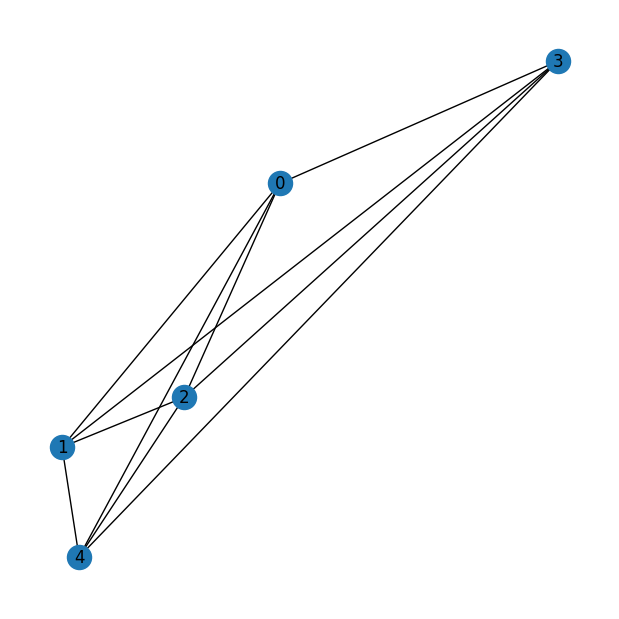

In [9]:
# the position helps to visualize the true graph. If pos is not passed to nx.draw, we lose information on 
# the position of the nodes (see the cell below this)
pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_size=300,with_labels=True)
plt.show()

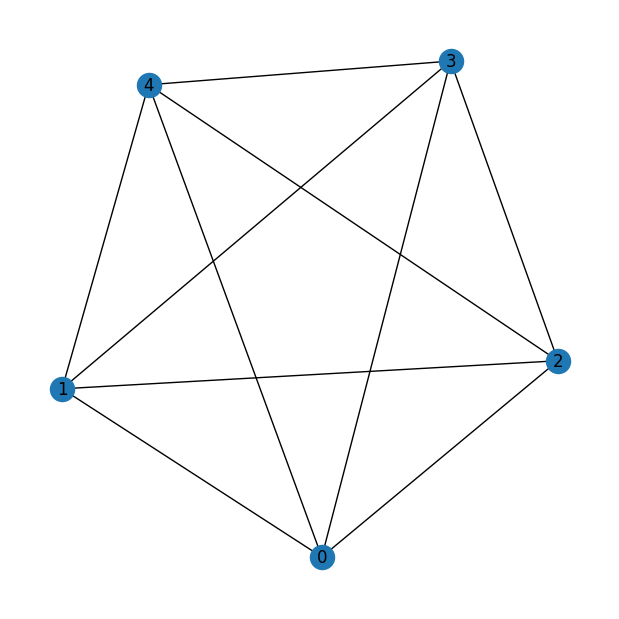

In [10]:
# this will give a neat graph 
plt.figure(figsize=(6, 6))
nx.draw(G,node_size=300,with_labels=True)
plt.show()

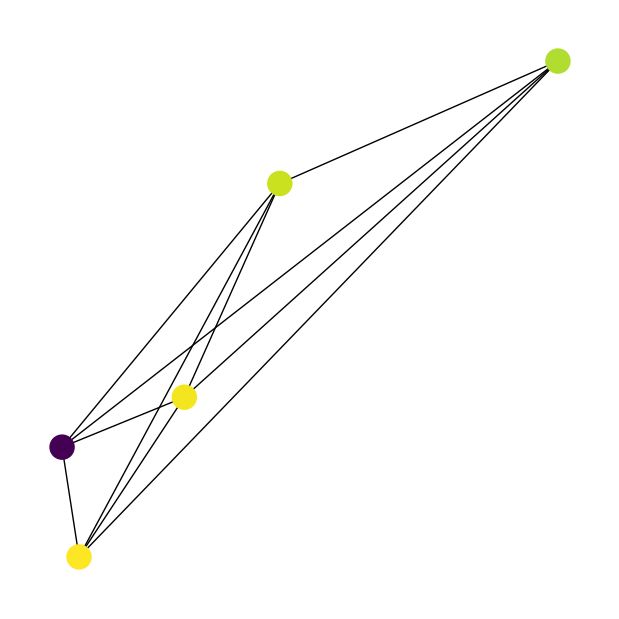

In [11]:
node_colors = data.x[:, 0].numpy()

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_color=node_colors,node_size=300,with_labels=False)
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
plt.show()


In [12]:
def create_random_graph(min_nodes=5, max_nodes=30, num_node_features=10, k=4):
    num_nodes = random.randint(min_nodes, max_nodes)

    x = torch.randn(num_nodes, num_node_features)

    pos = torch.randn(num_nodes, 2)

    edge_index = knn_graph(pos, k=k, loop=False)

    y = x.sum(dim=1).mean().unsqueeze(0)

    return Data(
        x=x,
        edge_index=edge_index,
        pos=pos,
        y=y
    )

In [13]:
def create_dataset(num_graphs=1000):
    dataset = []
    for _ in range(num_graphs):
        graph = create_random_graph()
        dataset.append(graph)
    return dataset

In [118]:
dataset = create_dataset(300)

In [119]:
print()
# print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset[0].x.shape[1]}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of graphs: 300
Number of features: 10

Data(x=[19, 10], edge_index=[2, 76], y=[1], pos=[19, 2])
Number of nodes: 19
Number of edges: 76
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [120]:
def plot_geometric_data_as_graph(data):
    G = to_networkx(data, to_undirected=True, node_attrs=['x'], edge_attrs=None)
    pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}
    fig = plt.figure(figsize=(6, 6))
    nx.draw(G,pos,node_size=300,with_labels=False)
    plt.show()
    fig.clear()

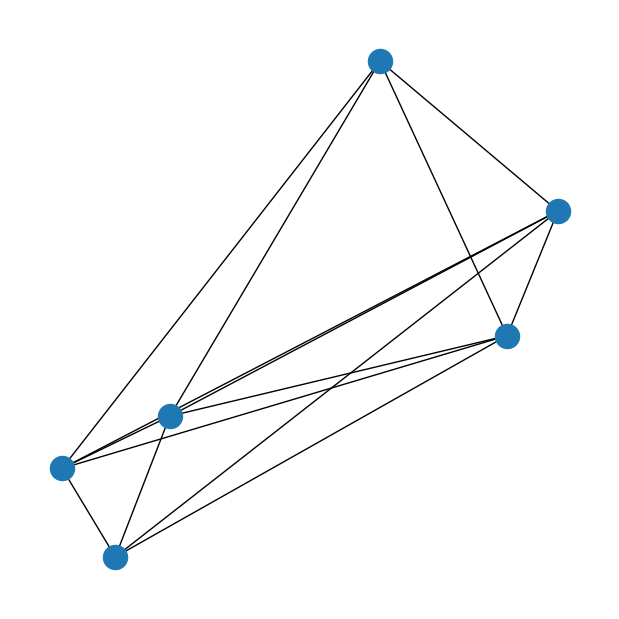

In [121]:
plot_geometric_data_as_graph(dataset[10])

### Splitting the dataset in to train and test dataset

In [122]:
train_dataset = dataset[:200]
val_dataset = dataset[200:260]
test_dataset = dataset[260:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 200
Number of validation graphs: 60
Number of test graphs: 40


In [123]:
print("Train y mean:", torch.cat([d.y for d in train_dataset]).mean())
print("Val y mean:", torch.cat([d.y for d in val_dataset]).mean())

Train y mean: tensor(-0.0363)
Val y mean: tensor(0.1240)


In [124]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1119, 10], edge_index=[2, 4476], y=[64], pos=[1119, 2], batch=[1119], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1066, 10], edge_index=[2, 4264], y=[64], pos=[1066, 2], batch=[1066], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1108, 10], edge_index=[2, 4432], y=[64], pos=[1108, 2], batch=[1108], ptr=[65])

Step 4:
Number of graphs in the current batch: 8
DataBatch(x=[141, 10], edge_index=[2, 564], y=[8], pos=[141, 2], batch=[141], ptr=[9])



In [125]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCNRegressor(torch.nn.Module):
    def __init__(self, num_node_features,hidden_channels):
        super(GCNRegressor, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

In [126]:
model = GCNRegressor(num_node_features=10,hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [127]:
def train():
    model.train()
    mse_total = 0
    loss_total = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out.squeeze(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        mse_value = F.mse_loss(out.squeeze(), data.y).detach().item()
        mse_total+=mse_value
        loss_total+=loss.item()
#         print(f'{out=}')
#         print(f'{data.y}')
#     print(mse_total)
    return mse_total / len(train_loader), out, loss_total/len(train_loader)

def test(loader):
    model.eval()
    mse_total = 0
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)  
            pred = out  # Use the class with highest probability.
            mse_value = F.mse_loss(out.squeeze(), data.y).detach().item()
            mse_total+=mse_value
    #         print(pred)
    #         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return mse_total / len(loader)  # Derive ratio of correct predictions.

In [128]:
train_mse = []
val_mse = []
loss = []
for epoch in range(1, 100):
    train_mse_epoch, out, loss_epoch = train()
    train_mse.append(train_mse_epoch)
    loss.append(loss_epoch)
    
#     train_mse = test(train_loader)
    val_mse_epoch = test(val_loader)
    val_mse.append(val_mse_epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss_epoch:.4f}, Train MSE: {train_mse_epoch:.4f}, Validation MSE: {val_mse_epoch:.4f}')
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.7006, Train MSE: 0.7006, Validation MSE: 0.7011
Epoch: 002, Loss: 0.6259, Train MSE: 0.6259, Validation MSE: 0.6735
Epoch: 003, Loss: 0.7216, Train MSE: 0.7216, Validation MSE: 0.6518
Epoch: 004, Loss: 0.5942, Train MSE: 0.5942, Validation MSE: 0.6300
Epoch: 005, Loss: 0.5817, Train MSE: 0.5817, Validation MSE: 0.6083
Epoch: 006, Loss: 0.8032, Train MSE: 0.8032, Validation MSE: 0.5916
Epoch: 007, Loss: 0.5214, Train MSE: 0.5214, Validation MSE: 0.5798
Epoch: 008, Loss: 0.5460, Train MSE: 0.5460, Validation MSE: 0.5631
Epoch: 009, Loss: 0.7760, Train MSE: 0.7760, Validation MSE: 0.5444
Epoch: 010, Loss: 0.5411, Train MSE: 0.5411, Validation MSE: 0.5225
Epoch: 011, Loss: 0.4962, Train MSE: 0.4962, Validation MSE: 0.5003
Epoch: 012, Loss: 0.4845, Train MSE: 0.4845, Validation MSE: 0.4744
Epoch: 013, Loss: 0.6446, Train MSE: 0.6446, Validation MSE: 0.4450
Epoch: 014, Loss: 0.5529, Train MSE: 0.5529, Validation MSE: 0.4068
Epoch: 015, Loss: 0.4133, Train MSE: 0.4133, Val

In [129]:
print(loss)

[0.700622633099556, 0.6259084641933441, 0.7215675711631775, 0.5942474976181984, 0.5816619098186493, 0.8032092303037643, 0.5213524512946606, 0.5460016056895256, 0.7760478556156158, 0.5411140322685242, 0.49619438499212265, 0.4845382794737816, 0.644593633711338, 0.552930198609829, 0.41329483315348625, 0.4273490458726883, 0.3590180352330208, 0.3684452250599861, 0.307208064943552, 0.3160577788949013, 0.28840893507003784, 0.20178571343421936, 0.20139354094862938, 0.18938075006008148, 0.2234560288488865, 0.16447990760207176, 0.16782011091709137, 0.17233561351895332, 0.14867812488228083, 0.16718126460909843, 0.17584164068102837, 0.15839276649057865, 0.13175161089748144, 0.17640580236911774, 0.1463163010776043, 0.1256128093227744, 0.14671664126217365, 0.15212649293243885, 0.1563841626048088, 0.1631767712533474, 0.1637958325445652, 0.13884115777909756, 0.14116507396101952, 0.12132252380251884, 0.1665413323789835, 0.1409036759287119, 0.15150754526257515, 0.14505437947809696, 0.13021549955010414, 

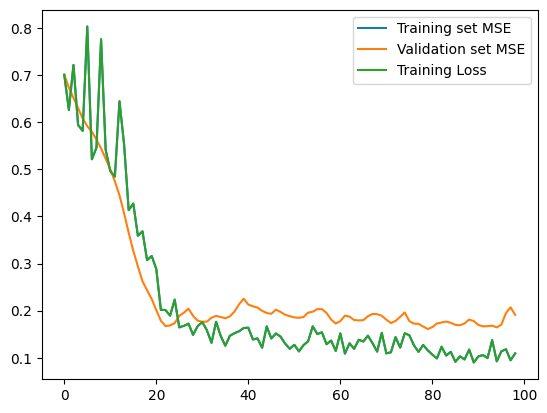

In [130]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(len(train_mse)), train_mse, label='Training set MSE')
plt.plot(range(len(val_mse)), val_mse, label='Validation set MSE')
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.legend()
plt.show()